In [2]:
import numpy as np
import pandas as pd
from numpy import save
from numpy import load
import random
import matplotlib.pyplot as plt
from scipy.stats import wishart
from numpy.random import multivariate_normal
from tqdm import tqdm
import math
from matplotlib import cm
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns

In [2]:
Sorted_rating = pd.read_csv('Preprocessed_Data.csv')
full_data=np.array(Sorted_rating[['ID-User-key','ID-Book-key','Book-Rating']])

In [3]:
std=np.std(full_data[:,2])
mean=np.mean(full_data[:,2])
Transformed=(full_data[:,2]-mean)/std
Transformed
max_users=np.max(full_data[:,0])
max_items=np.max(full_data[:,1])

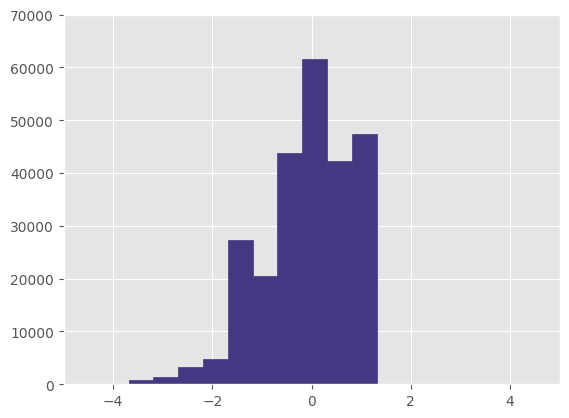

In [4]:
viridis = cm.get_cmap('viridis', 20)#(np.linspace(0.9, 0.1, 10))

colors = viridis(np.linspace(1,0, 20))
plt.style.use('ggplot')
fig=plt.figure()
ax=fig.add_subplot(111)
binwidth=0.5
ax.hist(Transformed, bins=np.arange(min(Transformed), max(Transformed)+ binwidth, binwidth), color=colors[16], edgecolor=colors[16])

ax.set_xlim(xmin=-5, xmax=5)
ax.set_ylim(ymin=0,ymax=70000)


plt.show()
fig.savefig('Figures/Transformed_ratings.png')

In [10]:
dim=30
lambda_=[0.01]
#lambda_=[0.01, 0.1, 1, 5, 10, 100]


for la in tqdm(lambda_):
    U=np.random.normal(0.0, 1.0/la, (dim,max_users+1))
    V=np.random.normal(0.0, 1.0/la,(dim,max_items+1))
    sim_rating=[]
    for i in range(len(Transformed)):

        sim_rating.append(np.random.normal(np.dot(U[:,full_data[i,0]].T , V[:,full_data[i,1]]),1))

    sim_rating=np.array(sim_rating)

    fig=plt.figure()
    ax=fig.add_subplot(111) 

    plt.figure(figsize=(3, 3))
    plt.style.use('ggplot')
    #ax1.set_title('Ratings')
    #ax2.set_title('simulated ratings')
    #ax1.hist(Transformed, bins=10)

    binwidth=0.5
    colors = viridis(np.linspace(1,0, 20))
    ax.hist(sim_rating, bins=np.arange(min(sim_rating), max(sim_rating)+ binwidth, binwidth), color=colors[8], edgecolor=colors[8])
    ax.set_xlim(xmin=-5, xmax=5)
    # Setting the values for all axes.
    #plt.show()
    fig.savefig(f'Figures/PMF_simulated_{la}.png')

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Doing same for BPMF to find appropiate beta
dim=30

#First need to simulate hyperparameters
graph=[]
betas=[1, 2, 5, 10]
scalar=[1, 10, 50, 200]
for h in tqdm(range(4)):
    for k in tqdm(range(4)):
        W_0=np.eye(dim)*scalar[h]
        V_0=dim
        beta_0=betas[k]
        sim_rating=[]
        mu_0=np.zeros((dim,1))

        lambda_U=wishart(df=V_0, scale=W_0).rvs()
        lambda_V=wishart(df=V_0, scale=W_0).rvs()
        cov_U=np.linalg.inv(beta_0*lambda_U)
        cov_V=np.linalg.inv(beta_0*lambda_V)
        mu_U=multivariate_normal(mu_0[:,0],cov_U)
        mu_V=multivariate_normal(mu_0[:,0],cov_V)
        cov_U=np.linalg.inv(lambda_U)
        cov_V=np.linalg.inv(lambda_V)
        U=np.empty((dim,max_users+1))
        V=np.empty(((dim,max_items+1)))
        for i in range(max_users):
            U[:,i]=multivariate_normal(mu_U,cov_U)
        for j in range(max_items):
            V[:,j]=multivariate_normal(mu_V,cov_V)
        sim_rating=[]
        #print(Transformed.shape)
        #print(U.shape)
        for i in range(len(Transformed)):
            sim_rating.append(np.random.normal(np.dot(U[:,full_data[i,0]].T, V[:,full_data[i,1]]),1))

        graph.append(sim_rating)

100%|██████████| 4/4 [10:29<00:00, 157.36s/it]


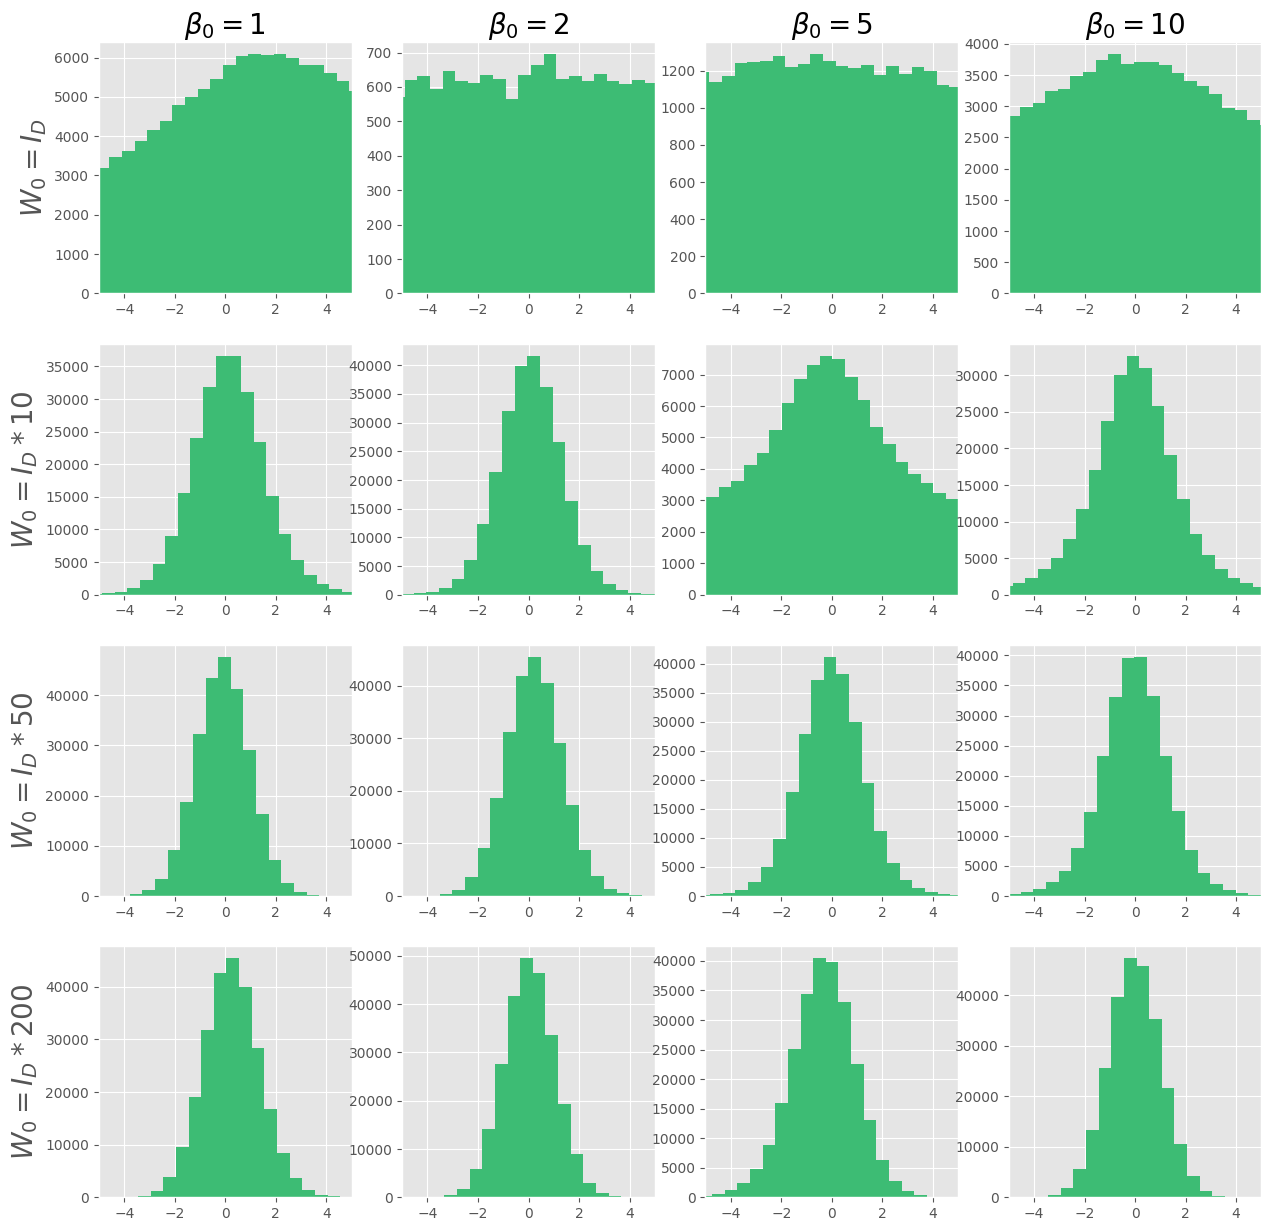

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))
plt.style.use('ggplot')
#ax2.set_title('simulated ratings')
#custom_xlim=((-4,4))
binwidth=0.5
viridis = cm.get_cmap('viridis', 20)
colors = viridis(np.linspace(1,0, 20))
for ax,i in zip(axs.ravel(),range(16)):

    ax.hist(graph[i], color = colors[6], bins=np.arange(min(graph[i]), max(graph[i])+ binwidth, binwidth))
    plt.setp(ax, xlim=(-5,5))
    
    #plt.setp(ax, ylim=(0,70000))


# Setting the values for all axes.
axs[0,0].set_title(r'$\beta_0=1$', fontsize=20)
axs[0,1].set_title(r'$\beta_0=2$', fontsize=20)
axs[0,2].set_title(r'$\beta_0=5$', fontsize=20)
axs[0,3].set_title(r'$\beta_0=10$', fontsize=20)

axs[0,0].set_ylabel(r'$W_0=I_D$', fontsize=20)
axs[1,0].set_ylabel(r'$W_0=I_D*10$', fontsize=20)
axs[2,0].set_ylabel(r'$W_0=I_D*50$', fontsize=20)
axs[3,0].set_ylabel(r'$W_0=I_D*200$', fontsize=20)


plt.show()
fig.savefig('Figures/Beta_simulated.png',bbox_inches='tight')

In [9]:
std=np.load('Data/rmse/bpmf_dim_10_burn_std.npy')
user_dim=np.load('Data/rmse/bpmf_dim_10_user_item_dim_burn_in.npy').astype(int)

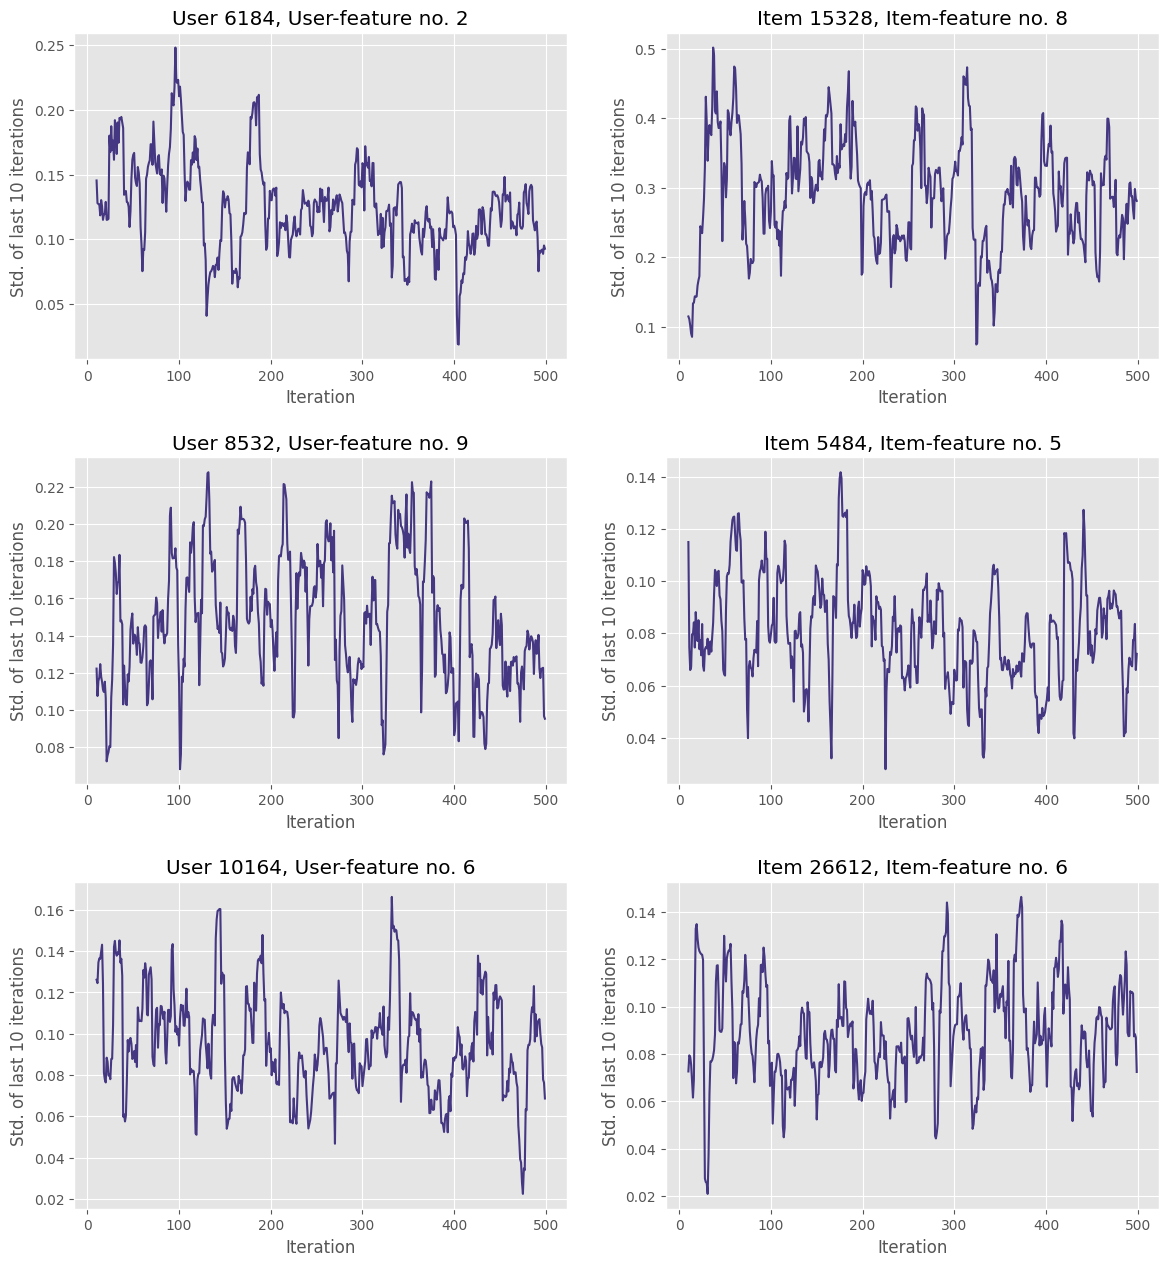

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(14,12))
plt.style.use('ggplot')
#ax2.set_title('simulated ratings')
#custom_xlim=((-4,4))
binwidth=0.5
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)

viridis = cm.get_cmap('viridis', 20)
colors = viridis(np.linspace(1,0, 20))
for ax,i in zip(axs.ravel(),range(6)):

    ax.plot(range(10,np.shape(std)[1]+10), std[i,:], color=colors[16])
    ax.set_ylabel('Std. of last 10 iterations')
    ax.set_xlabel('Iteration')      
   


# Setting the values for all axes.
axs[0,0].set_title(f'User {user_dim[0,1]}, User-feature no. {user_dim[0,0]}')
axs[1,0].set_title(f'User {user_dim[1,1]}, User-feature no. {user_dim[1,0]}')
axs[2,0].set_title(f'User {user_dim[2,1]}, User-feature no. {user_dim[2,0]}')

axs[0,1].set_title(f'Item {user_dim[3,1]}, Item-feature no. {user_dim[3,0]}')
axs[1,1].set_title(f'Item {user_dim[4,1]}, Item-feature no. {user_dim[4,0]}')
axs[2,1].set_title(f'Item {user_dim[5,1]}, Item-feature no. {user_dim[5,0]}')


fig.savefig('Figures/BPMF_burn_in_10.png',bbox_inches='tight')

In [30]:
std=np.load('Data/rmse/bpmf_dim_30_burn_std_alt.npy')
user_dim=np.load('Data/rmse/bpmf_dim_30_user_item_dim_burn_in_alt.npy').astype(int)

In [3]:
std=np.load('Data/rmse/bpmfuric_dim_30_burn_std.npy')
user_dim=np.load('Data/rmse/bpmfuric_dim_30_user_item_dim_burn_in.npy').astype(int)

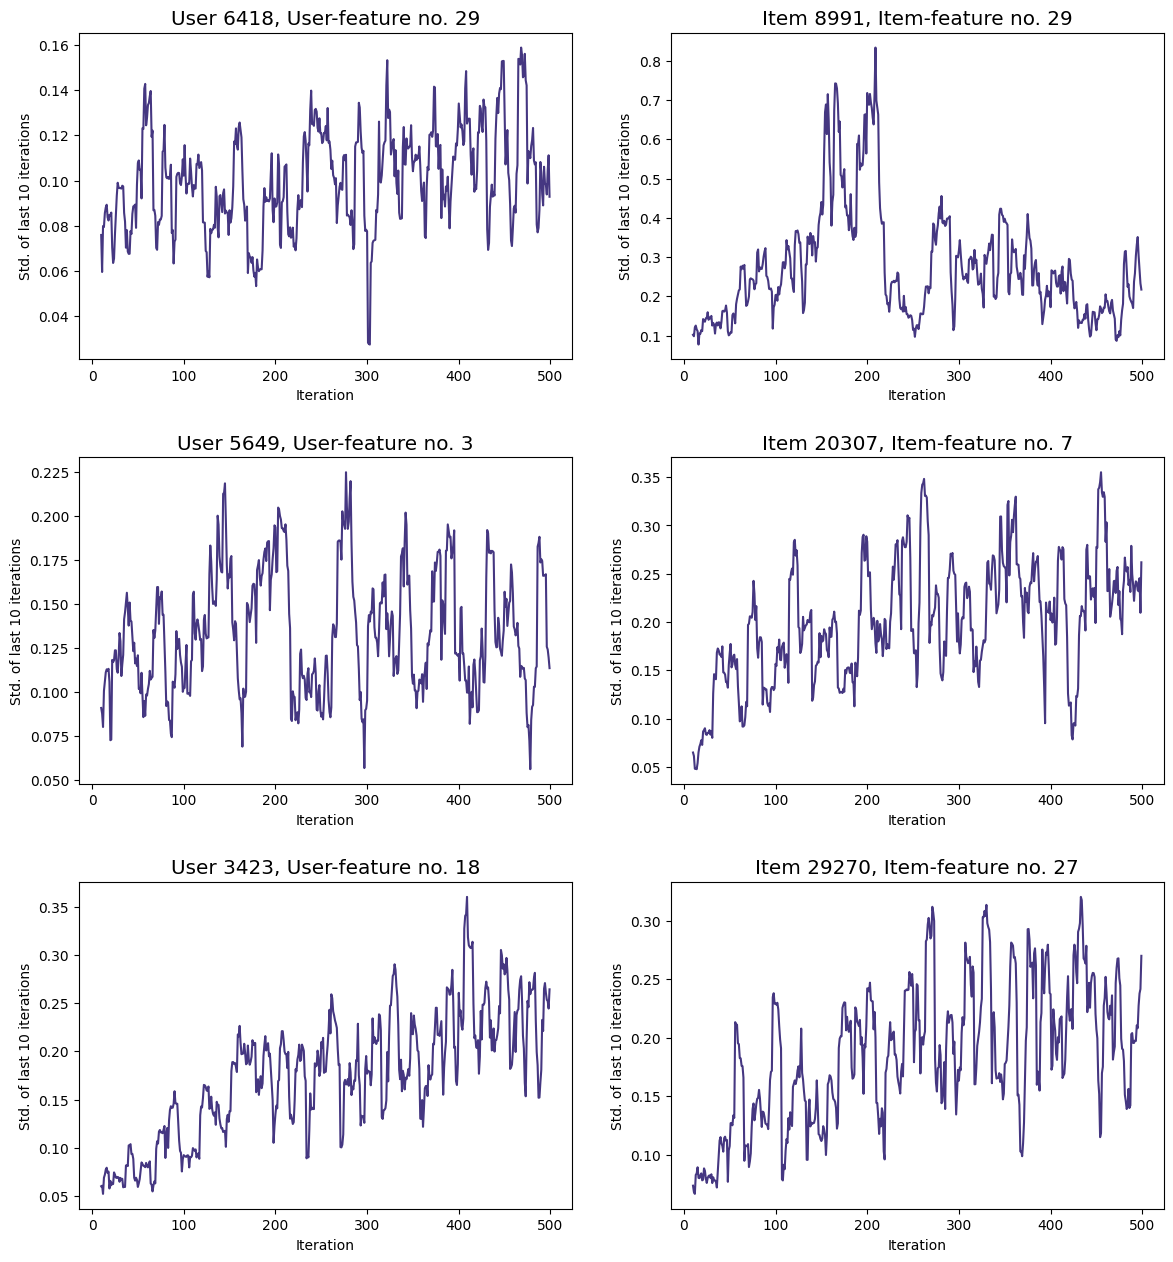

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(14,12))
plt.style.use('ggplot')
#ax2.set_title('simulated ratings')
#custom_xlim=((-4,4))
binwidth=0.5
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)

viridis = cm.get_cmap('viridis', 20)
colors = viridis(np.linspace(1,0, 20))
for ax,i in zip(axs.ravel(),range(6)):

    ax.plot(range(10,np.shape(std)[1]+10), std[i,:], color=colors[16])
    ax.set_ylabel('Std. of last 10 iterations')
    ax.set_xlabel('Iteration')      
   


# Setting the values for all axes.
axs[0,0].set_title(f'User {user_dim[0,1]}, User-feature no. {user_dim[0,0]}')
axs[1,0].set_title(f'User {user_dim[1,1]}, User-feature no. {user_dim[1,0]}')
axs[2,0].set_title(f'User {user_dim[2,1]}, User-feature no. {user_dim[2,0]}')

axs[0,1].set_title(f'Item {user_dim[3,1]}, Item-feature no. {user_dim[3,0]}')
axs[1,1].set_title(f'Item {user_dim[4,1]}, Item-feature no. {user_dim[4,0]}')
axs[2,1].set_title(f'Item {user_dim[5,1]}, Item-feature no. {user_dim[5,0]}')

fig.savefig('Figures/BPMFURIC_burn_in_30.png',bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

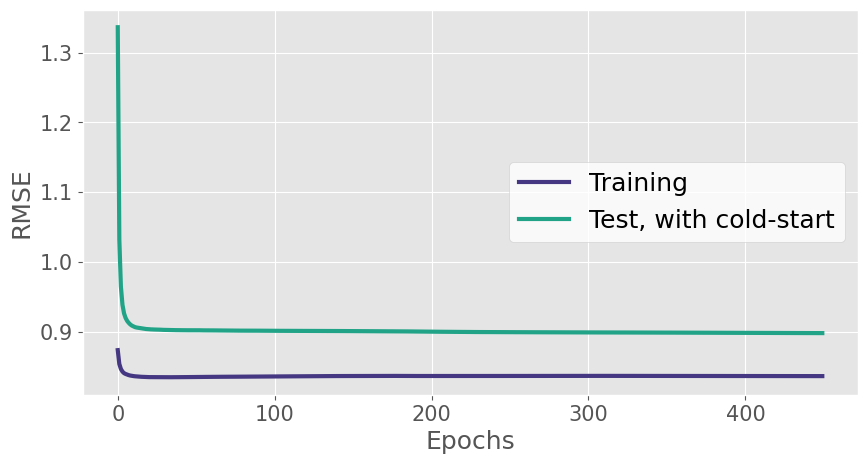

In [34]:
Dimension_=[ 30]


for i in Dimension_:

    pmf_rmse_train=np.load(f'Data/rmse/bpmf_rmse_train_dim_{i}.npy')
    pmf_rmse_test=np.load(f'Data/rmse/bpmf_rmse_test_dim_{i}.npy')
 
    #pmf_rmse_test_modi=np.load(f'Data/rmse/bpmf_rmse_test_modi_dim_{i}_lambda_5.npy')
    plt.clf()
    plt.figure(figsize=(10,5))
    viridis = cm.get_cmap('viridis', 20)#(np.linspace(0.9, 0.1, 10)
    colors = viridis(np.linspace(1,0, 20))

    plt.plot(range(np.shape(pmf_rmse_train)[0]), pmf_rmse_train, label='Training', color=colors[16], linewidth=3.0)
    plt.plot(range(np.shape(pmf_rmse_test)[0]), pmf_rmse_test, label='Test, with cold-start', color=colors[8], linewidth=3.0)
    #plt.plot(range(np.shape(pmf_rmse_test_modi)[0]-11), pmf_rmse_test_modi[:50], label='Test, Without cold-start', color=colors[2], linewidth=3.0, linestyle='dotted')
    #plt.plot(range(np.shape(pmf_rmse_test_modi_30)[0]), pmf_rmse_test_modi_30, label='Modified test data',color='r', linestyle='dotted')

    plt.legend()
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('RMSE', fontsize=18)
    plt.legend(loc="center right", facecolor='white', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
    #plt.savefig(f'Figures/bpmf_startvalue.png')

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

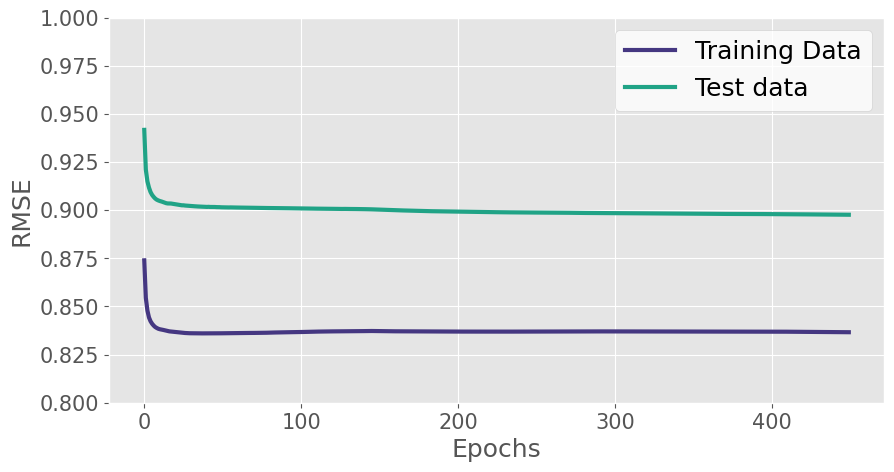

In [42]:
Dimension_=[10, 30, 50]
rmse=[]
rmse_train=[]

for i in Dimension_:

    bpmf_rmse_train=np.load(f'Data/rmse/bpmf_rmse_train_dim_{i}.npy')
    bpmf_rmse_test=np.load(f'Data/rmse/bpmf_rmse_test_dim_{i}.npy')
    #pmf_rmse_test_modi_30_5=np.load('Data/rmse/pmf_rmse_test_modi_dim_30_lambda_{i}.npy')
    plt.clf()
    plt.figure(figsize=(10,5))
    viridis = cm.get_cmap('viridis', 20)#(np.linspace(0.9, 0.1, 10)
    colors = viridis(np.linspace(1,0, 20))

    plt.plot(range(np.shape(bpmf_rmse_train)[0]), bpmf_rmse_train, label='Training Data', color=colors[16], linewidth=3.0)
    plt.plot(range(np.shape(bpmf_rmse_test)[0]), bpmf_rmse_test, label='Test data', color=colors[8], linewidth=3.0)
    #plt.plot(range(np.shape(pmf_rmse_test_modi_30)[0]), pmf_rmse_test_modi_30, label='Modified test data',color='r', linestyle='dotted')

    plt.legend()
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('RMSE', fontsize=18)
    plt.legend(loc="upper right", facecolor='white', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(0.8,1)
    plt.savefig(f'Figures/bpmf_rmse_dim_{i}.png')
    rmse.append(bpmf_rmse_test[-1])
    rmse_train.append(bpmf_rmse_train[-1])
    #plt.title(r'D=30,   $\lambda_{U/V}=5$')


In [43]:
for i,j in zip(Dimension_,range(3)):
    MAE=np.load(f'Data/rmse/bpmf_MAE_dim_{i}.npy')
   
    print(' Dim', str(i), ' test rmse: ',rmse[j] ,' train rmse: ', rmse_train[j])
    print(' Dim ', str(i), ' test MAE: ', MAE[1],' train MAE: ', MAE[0])

 Dim 10  test rmse:  0.8902294210999513  train rmse:  0.821181700319083
 Dim  10  test MAE:  0.6935124458203729  train MAE:  0.6403518196206223
 Dim 30  test rmse:  0.8977443936079597  train rmse:  0.8360769478807454
 Dim  30  test MAE:  0.699029903456453  train MAE:  0.6516083228482843
 Dim 50  test rmse:  0.8976519908289765  train rmse:  0.8366266535027833
 Dim  50  test MAE:  0.6990151638519709  train MAE:  0.6520184938600204


In [51]:
hp_predict=np.load('Data/pred/bpmf_HP_predict_dim_30.npy')


In [81]:
param=np.load('Data/pred/pmf_transformation.npy')
last=np.minimum(hp_predict*param[0]+param[1],10)

In [82]:
np.percentile(last,97.5)

9.833439335872757

In [83]:
np.percentile(last,2.5)

7.627562101767336

In [181]:
user_13=np.load('Data/pred/bpmf_13013_predict_dim_30.npy')
user_13=user_13.reshape((-1,))

In [184]:
ratings=user_13*param[0]+param[1]
idx=np.argsort(ratings)[::-1]
top=np.sort(ratings)[::-1]
top10=top[:15].tolist()
idx10=idx[:15].tolist()

In [84]:
predict=np.load('Data/pred/bpmf_Other_predict_dim_30.npy')

In [93]:
first=np.maximum(np.minimum(predict[:,:3]*param[0]+param[1],10),1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/lines.py:1206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


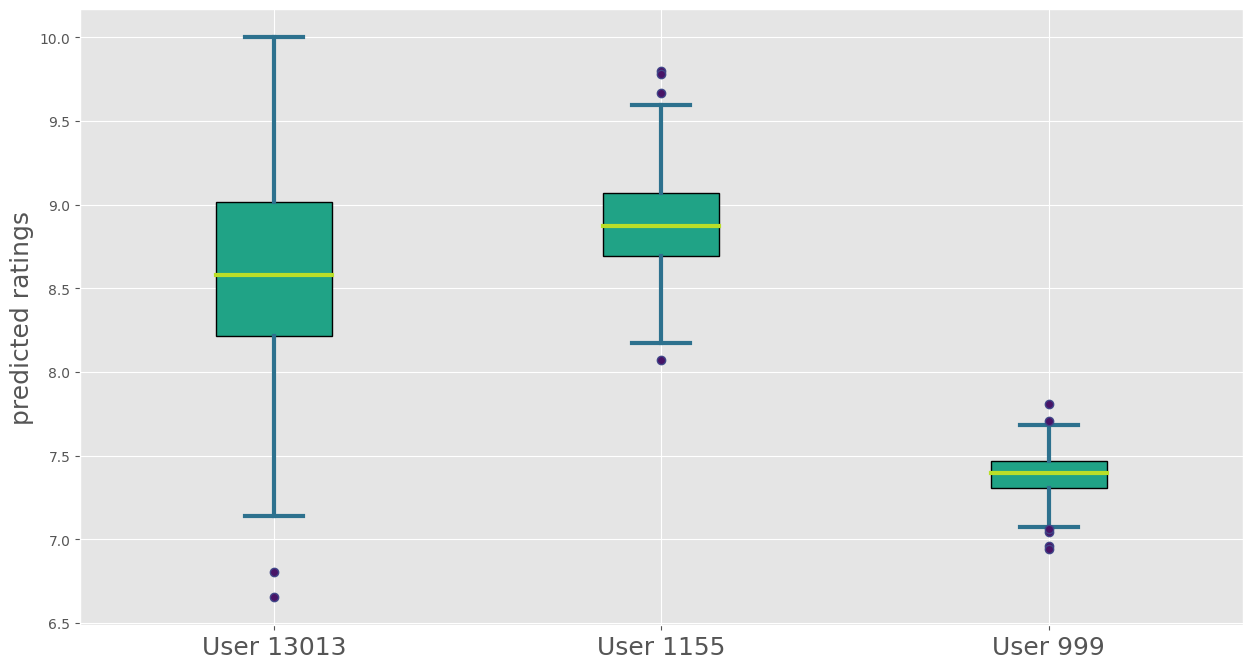

In [122]:
_fig = plt.figure(figsize =(15, 8)) 
_ax = _fig.add_subplot(111) 


_bp = _ax.boxplot(first, labels=['User 13013','User 1155','User 999'],patch_artist = True)
_ax.set_ylabel('predicted ratings', fontsize=18)
_ax.set_xticklabels(['User 13013','User 1155','User 999'], fontsize=18)

viridis = cm.get_cmap('viridis', 20)#(np.linspace(0.9, 0.1, 10)
c = viridis(np.linspace(1,0, 20))

_colors=[c[8],c[8],c[8]]
for patch, color in zip(_bp['boxes'], _colors): patch.set_facecolor(color) 
 
# Whisker color and line width can be changed.
for whisker in _bp['whiskers']: whisker.set(color = c[12], linewidth = 3) 
 
# color and line width of caps can be changed
for cap in _bp['caps']: cap.set(color = c[12], linewidth = 3) 
 
# Color and linewidth of medians can be changed.
for median in _bp['medians']: median.set(color =c[2], linewidth = 3) 
 
# changing style of fliers 
for flier in _bp['fliers']: flier.set(markerfacecolor =c[18], markeredgecolor=c[15]) 

plt.savefig(f'Figures/bpmf_boxplot.png')

<Figure size 640x480 with 0 Axes>

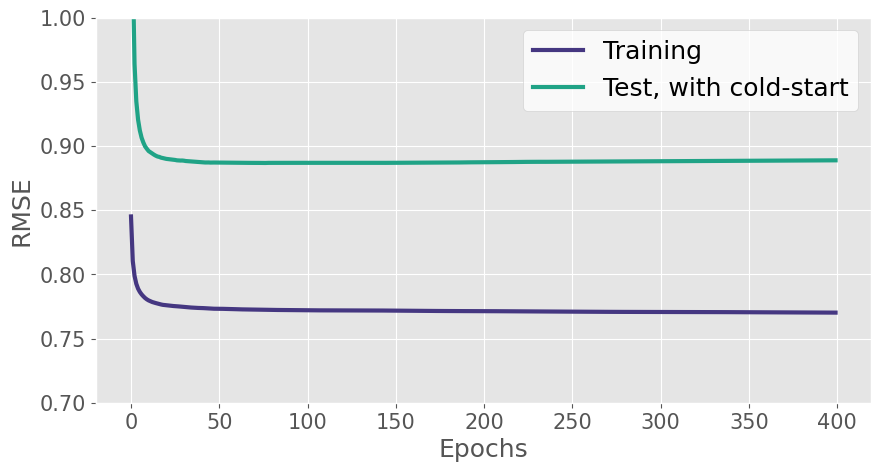

In [7]:
pmf_rmse_train=np.load(f'Data/rmse/bpmfuric_rmse_train_dim_10.npy')
pmf_rmse_test=np.load(f'Data/rmse/bpmfuric_rmse_test_dim_10.npy')

#pmf_rmse_test_modi=np.load(f'Data/rmse/bpmf_rmse_test_modi_dim_{i}_lambda_5.npy')
plt.clf()
plt.figure(figsize=(10,5))
viridis = cm.get_cmap('viridis', 20)#(np.linspace(0.9, 0.1, 10)
colors = viridis(np.linspace(1,0, 20))
plt.plot(range(np.shape(pmf_rmse_train)[0]), pmf_rmse_train, label='Training', color=colors[16], linewidth=3.0)
plt.plot(range(np.shape(pmf_rmse_test)[0]), pmf_rmse_test, label='Test, with cold-start', color=colors[8], linewidth=3.0)
#plt.plot(range(np.shape(pmf_rmse_test_modi)[0]-11), pmf_rmse_test_modi[:50], label='Test, Without cold-start', color=colors[2], linewidth=3.0, linestyle='dotted')
#plt.plot(range(np.shape(pmf_rmse_test_modi_30)[0]), pmf_rmse_test_modi_30, label='Modified test data',color='r', linestyle='dotted')
plt.legend()
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.ylim(0.7,1)
plt.legend(loc="upper right", facecolor='white', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(f'Figures/bpmfuric_rmse_dim_10.png')

In [8]:
MAE=np.load(f'Data/rmse/bpmfuric_MAE_dim_10.npy')
   
print(' Dim', 10, ' test rmse: ',pmf_rmse_test[-1] ,' train rmse: ', pmf_rmse_train[-1])
print(' Dim ', 10, ' test MAE: ', MAE[1],' train MAE: ', MAE[0])

 Dim 10  test rmse:  0.8888804742162386  train rmse:  0.7702121474494475
 Dim  10  test MAE:  0.689253872181943  train MAE:  0.6008316437621314


In [207]:
pmf_rmse_test[-1]

0.8888804742162386